This notebook will walk you through the process of the preparation your data for retentioneering analysis and basic use

Review of the basic Retentioneering functions: 

get_edgelist()  
get_adjacency()  
plot_graph()  

We will review what options for normalization you can use to explore your dataset.

<a id="0"></a>

# Table of context

1. [Data preparation](#1)
2. [Transition weights overview](#2)
3. [Weighting by Events](#3)  
    3.1 [Events: no normalization](#3.1)  
    3.2 [Events: normalized 'full'](#3.2)      
    3.3 [Events: normalized 'node'](#3.3)  
4. [Weighting by Users](#4)   
    4.1 [Users: no normalization](#4.1)  
    4.2 [Users: normalized 'full'](#4.2)  
    4.3 [Users: normalized 'node'](#4.3)    
    

In [1]:
from retentioneering import init_config
from retentioneering import datasets
import pandas as pd
import numpy as np

In [2]:
data = datasets.load_simple_shop()

In [3]:
data.head()

,client_id,event,timestamp
0,219483890,products,2019-11-01 17:59:13.273932
1,219483890,product1,2019-11-01 17:59:28.459271
2,219483890,cart,2019-11-01 17:59:29.502214
3,219483890,products,2019-11-01 17:59:32.557029
4,219483890,lost,2019-11-01 17:59:47.814036


<a id="1"></a>

# 1. Data preparation
[top](#0)

In [4]:
init_config(
    experiments_folder='experiments', # folder for saving experiment results: graph visualization, heatmaps and etc.
    index_col='client_id', # column by which we split users / sessions / whatever
    event_col='event', # column that describes event
    event_time_col='timestamp', # column that describes timestamp of event
    positive_target_event='passed', # name of positive target event
    negative_target_event='lost', # name of negative target event
    pos_target_definition={ # how to define positive event, e.g. empty means that add passed for whom was not 'lost'
        'event_list': ['payment_done']
    },
    neg_target_definition={}
)

data = data.retention.prepare()

In [5]:
data.head()

,client_id,event,timestamp
0,219483890,products,2019-11-01 17:59:13.273932
1,219483890,product1,2019-11-01 17:59:28.459271
2,219483890,cart,2019-11-01 17:59:29.502214
3,219483890,products,2019-11-01 17:59:32.557029
4,219483890,lost,2019-11-01 17:59:47.814036


In [6]:
#number of converted users in dataset:
print('pos events:', len(data[data['event'] == 'passed']))

pos events: 704


In [7]:
#data = data.retention.split_sessions(thresh=30*60*24*3)

# add session id column

<a id="2"></a>

# 2. Transitions weight functions
[top](#0)

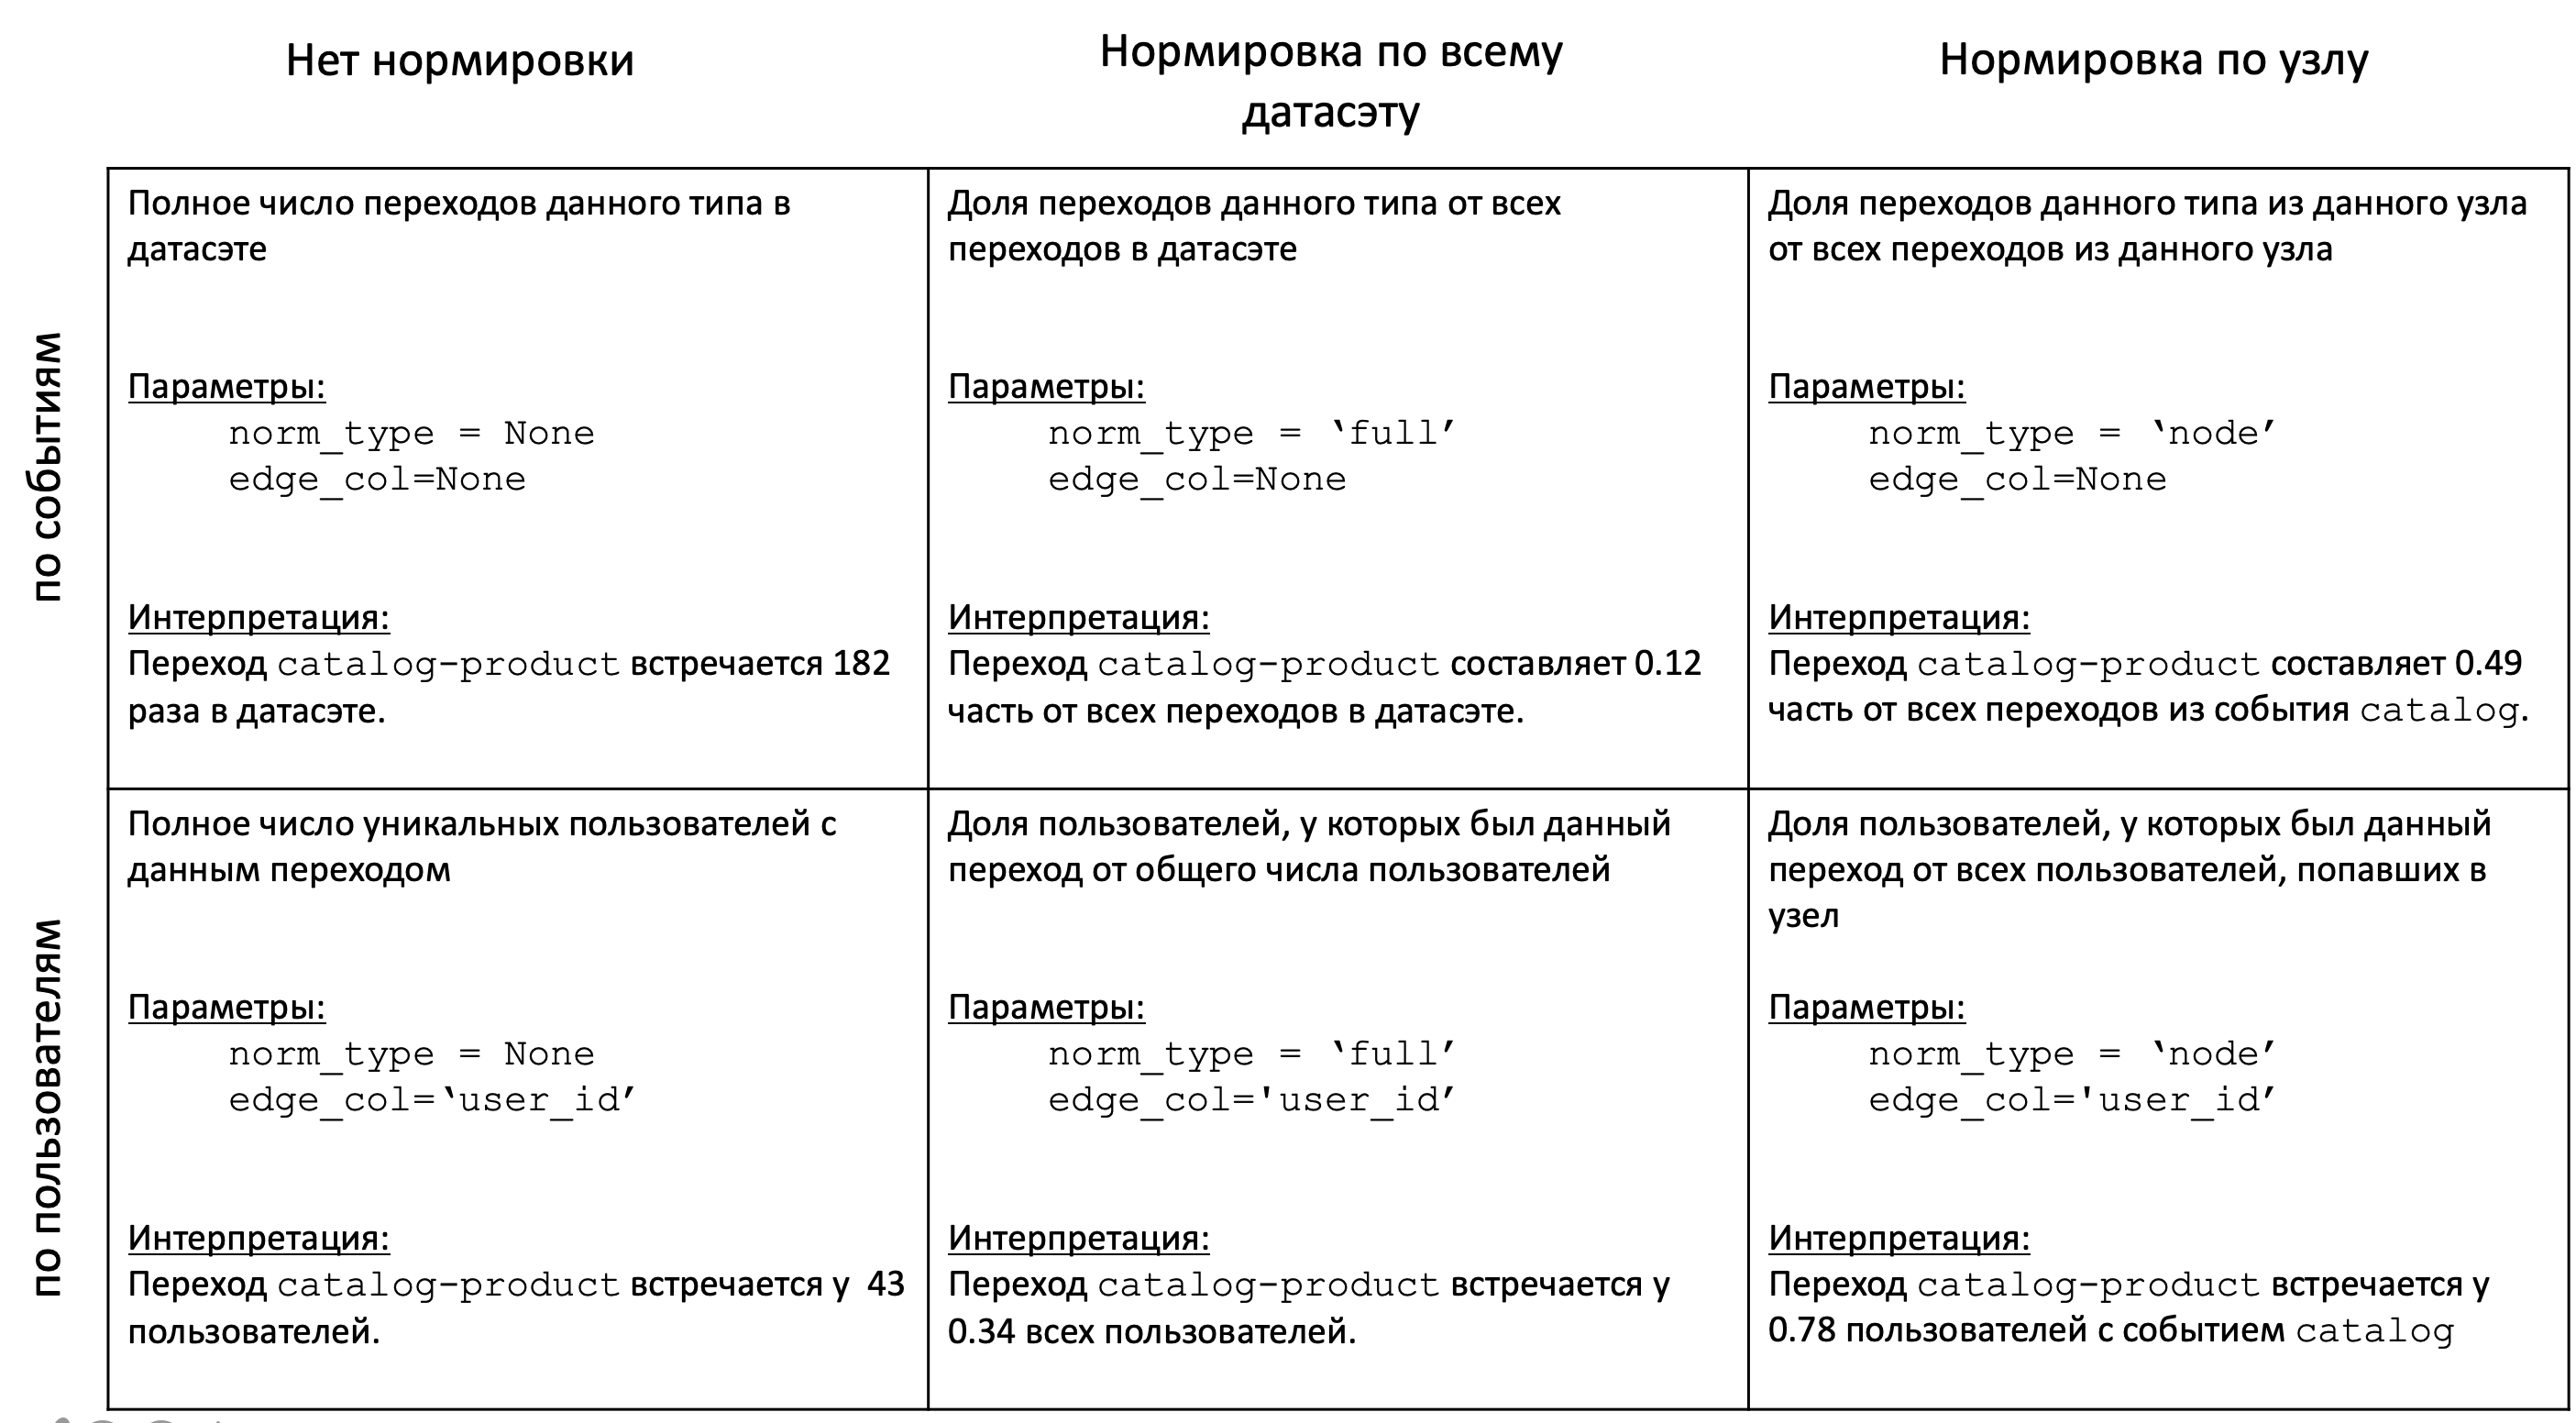

In [8]:
#TEMP: for control purpose only
test = data.retention.get_shift()
test['bi_gram'] = test['event'] + '~~~' + test['next_event']

<a id="3"></a>
## 3. Weighting by events

<a id="3.1"></a>
### 3.1 Events: no normalization
[top](#0)

In [9]:
test['bi_gram'].value_counts()

products~~~products                   4854
main~~~products                       4062
products~~~lost                       2855
lost~~~main                           2438
products~~~product2                   2170
products~~~cart                       1708
cart~~~delivery_choice                1684
products~~~product1                   1515
products~~~main                       1410
product2~~~products                   1297
main~~~lost                           1117
delivery_choice~~~delivery_courier     832
product1~~~products                    750
delivery_courier~~~payment_choice      750
product2~~~cart                        659
cart~~~lost                            584
cart~~~products                        571
payment_choice~~~payment_card          565
payment_card~~~passed                  507
delivery_choice~~~delivery_pickup      506
product1~~~cart                        472
main~~~main                            453
delivery_pickup~~~payment_choice       355
product1~~~

In [10]:
edgelist = data.retention.get_edgelist(norm_type=None,
                                       edge_col=None)

edgelist.sort_values('edge_weight', ascending=False).head(5)

,event,next_event,edge_weight
36,products,products,4854
14,main,products,4062
32,products,lost,2855
11,lost,main,2438
35,products,product2,2170


In [11]:
adj_matrix=data.retention.get_adjacency(norm_type=None,
                                        edge_col=None)
adj_matrix

,cart,delivery_choice,lost,products,delivery_courier,delivery_pickup,payment_choice,main,passed,payment_card,payment_cash,product1,product2
cart,0.0,1684.0,584.0,571.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
delivery_choice,0.0,0.0,168.0,178.0,832.0,506.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
lost,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2438.0,0.0,0.0,0.0,0.0,0.0
products,1708.0,0.0,2855.0,4854.0,0.0,0.0,0.0,1410.0,0.0,0.0,0.0,1515.0,2170.0
delivery_courier,0.0,0.0,82.0,0.0,0.0,0.0,750.0,0.0,0.0,0.0,0.0,0.0,0.0
delivery_pickup,0.0,0.0,151.0,0.0,0.0,0.0,355.0,0.0,0.0,0.0,0.0,0.0,0.0
payment_choice,0.0,0.0,136.0,114.0,0.0,0.0,0.0,0.0,95.0,565.0,195.0,0.0,0.0
main,0.0,0.0,1117.0,4062.0,0.0,0.0,0.0,453.0,0.0,0.0,0.0,0.0,0.0
passed,0.0,0.0,0.0,0.0,0.0,0.0,0.0,267.0,0.0,0.0,0.0,0.0,0.0
payment_card,0.0,0.0,58.0,0.0,0.0,0.0,0.0,0.0,507.0,0.0,0.0,0.0,0.0


In [12]:
data.retention.plot_graph(node_params = {'facebook':'source','blog':'source', 'lost':'bad_target', 'passed': 'nice_target'},
                          norm_type=None,
                          edge_col=None)

'experiments/index_2020-05-28 15_10_21_659326.html'

<a id="3.2"></a>
### 3.2 Events: normalized 'full'
[top](#0)

In [13]:
test['bi_gram'].value_counts(normalize=True)

products~~~products                   0.141681
main~~~products                       0.118564
products~~~lost                       0.083333
lost~~~main                           0.071162
products~~~product2                   0.063339
products~~~cart                       0.049854
cart~~~delivery_choice                0.049154
products~~~product1                   0.044221
products~~~main                       0.041156
product2~~~products                   0.037858
main~~~lost                           0.032604
delivery_choice~~~delivery_courier    0.024285
delivery_courier~~~payment_choice     0.021891
product1~~~products                   0.021891
product2~~~cart                       0.019235
cart~~~lost                           0.017046
cart~~~products                       0.016667
payment_choice~~~payment_card         0.016492
payment_card~~~passed                 0.014799
delivery_choice~~~delivery_pickup     0.014769
product1~~~cart                       0.013777
main~~~main  

In [14]:
edgelist = data.retention.get_edgelist(norm_type='full',
                                       edge_col=None)

edgelist.sort_values('edge_weight', ascending=False).head(5)

,event,next_event,edge_weight
36,products,products,0.141681
14,main,products,0.118564
32,products,lost,0.083333
11,lost,main,0.071162
35,products,product2,0.063339


In [15]:
adj_matrix=data.retention.get_adjacency(norm_type='full',
                                        edge_col=None)
adj_matrix

,cart,delivery_choice,lost,products,delivery_courier,delivery_pickup,payment_choice,main,passed,payment_card,payment_cash,product1,product2
cart,0.000000,0.049154,0.017046,0.016667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
delivery_choice,0.000000,0.000000,0.004904,0.005196,0.024285,0.014769,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
lost,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.071162,0.000000,0.000000,0.000000,0.000000,0.000000
products,0.049854,0.000000,0.083333,0.141681,0.000000,0.000000,0.000000,0.041156,0.000000,0.000000,0.000000,0.044221,0.063339
delivery_courier,0.000000,0.000000,0.002393,0.000000,0.000000,0.000000,0.021891,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
delivery_pickup,0.000000,0.000000,0.004407,0.000000,0.000000,0.000000,0.010362,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
payment_choice,0.000000,0.000000,0.003970,0.003327,0.000000,0.000000,0.000000,0.000000,0.002773,0.016492,0.005692,0.000000,0.000000
main,0.000000,0.000000,0.032604,0.118564,0.000000,0.000000,0.000000,0.013222,0.000000,0.000000,0.000000,0.000000,0.000000
passed,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.007793,0.000000,0.000000,0.000000,0.000000,0.000000
payment_card,0.000000,0.000000,0.001693,0.000000,0.000000,0.000000,0.000000,0.000000,0.014799,0.000000,0.000000,0.000000,0.000000


In [16]:
data.retention.plot_graph(node_params = {'facebook':'source','blog':'source', 'lost':'bad_target', 'passed': 'nice_target'},
                          norm_type='full',
                          edge_col=None)

'experiments/index_2020-05-28 12_34_57_228961.html'

<a id="3.3"></a>
### 3.3 Events: normalized 'node'
[top](#0)

In [24]:
node_counts = test.groupby('event')['bi_gram'].count()
g_test = test.groupby('bi_gram').agg({'event':'first', 
                                      'timestamp': 'count'}).reset_index()

g_test['node_norm'] = g_test['timestamp'] / node_counts.loc[g_test['event']].values

g_test[g_test['event']=='cart']

,bi_gram,event,timestamp,node_norm
0,cart~~~delivery_choice,cart,1684,0.593167
1,cart~~~lost,cart,584,0.205706
2,cart~~~products,cart,571,0.201127


In [26]:
g_test[g_test['event']=='cart']['node_norm'].sum()

1.0

In [18]:
edgelist = data.retention.get_edgelist(norm_type='node',
                                       edge_col=None,)

edgelist.sort_values('edge_weight', ascending=False).head(5)

,event,next_event,edge_weight
8,delivery_courier,payment_choice,0.901442
17,payment_card,passed,0.897345
14,main,products,0.721236
10,delivery_pickup,payment_choice,0.701581
30,product2,products,0.597696


In [19]:
adj_matrix=data.retention.get_adjacency(norm_type='node', 
                                        edge_col=None,)
adj_matrix

,cart,delivery_choice,lost,products,delivery_courier,delivery_pickup,payment_choice,main,passed,payment_card,payment_cash,product1,product2
cart,0.000000,0.593167,0.205706,0.201127,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
delivery_choice,0.000000,0.000000,0.099762,0.105701,0.494062,0.300475,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
lost,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.423926,0.000000,0.000000,0.000000,0.000000,0.000000
products,0.117696,0.000000,0.196734,0.334482,0.000000,0.000000,0.000000,0.097161,0.000000,0.000000,0.000000,0.104396,0.149531
delivery_courier,0.000000,0.000000,0.098558,0.000000,0.000000,0.000000,0.901442,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
delivery_pickup,0.000000,0.000000,0.298419,0.000000,0.000000,0.000000,0.701581,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
payment_choice,0.000000,0.000000,0.123077,0.103167,0.000000,0.000000,0.000000,0.000000,0.085973,0.511312,0.176471,0.000000,0.000000
main,0.000000,0.000000,0.198331,0.721236,0.000000,0.000000,0.000000,0.080433,0.000000,0.000000,0.000000,0.000000,0.000000
passed,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.379261,0.000000,0.000000,0.000000,0.000000,0.000000
payment_card,0.000000,0.000000,0.102655,0.000000,0.000000,0.000000,0.000000,0.000000,0.897345,0.000000,0.000000,0.000000,0.000000


In [22]:
adj_matrix.loc['cart'].sum()

1.0

In [21]:
data.retention.plot_graph(node_params = {'facebook':'source','blog':'source', 'lost':'bad_target', 'passed': 'nice_target'},
                          norm_type='node',
                          edge_col=None)

'experiments/index_2020-05-28 12_35_11_128143.html'

<a id="4"></a>
# 4. Weighted by users

<a id="4.1"></a>
### 4.1 Users: no normalization
[top](#0)

In [28]:
test.groupby(['bi_gram'])['client_id'].agg(lambda x: x.nunique()).sort_values(ascending=False)

bi_gram
products~~~lost                       2178
main~~~products                       2014
products~~~products                   2003
products~~~product2                   1429
cart~~~delivery_choice                1355
products~~~cart                       1323
lost~~~main                           1211
products~~~product1                   1122
products~~~main                       1019
product2~~~products                    933
delivery_choice~~~delivery_courier     747
delivery_courier~~~payment_choice      682
main~~~lost                            679
product1~~~products                    620
product2~~~cart                        581
cart~~~lost                            536
payment_choice~~~payment_card          521
cart~~~products                        478
payment_card~~~passed                  475
delivery_choice~~~delivery_pickup      469
product1~~~cart                        431
main~~~main                            364
delivery_pickup~~~payment_choice       332
pro

In [29]:
edgelist = data.retention.get_edgelist(norm_type=None,
                                       edge_col='client_id',)

edgelist.sort_values('edge_weight', ascending=False).head(5)

,event,next_event,edge_weight
32,products,lost,2178
14,main,products,2014
36,products,products,2003
35,products,product2,1429
0,cart,delivery_choice,1355


In [30]:
adj_matrix=data.retention.get_adjacency(norm_type=None, 
                                        edge_col='client_id', )
adj_matrix

,cart,delivery_choice,lost,products,delivery_courier,delivery_pickup,payment_choice,main,passed,payment_card,payment_cash,product1,product2
cart,0.0,1355.0,536.0,478.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
delivery_choice,0.0,0.0,164.0,172.0,747.0,469.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
lost,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1211.0,0.0,0.0,0.0,0.0,0.0
products,1323.0,0.0,2178.0,2003.0,0.0,0.0,0.0,1019.0,0.0,0.0,0.0,1122.0,1429.0
delivery_courier,0.0,0.0,78.0,0.0,0.0,0.0,682.0,0.0,0.0,0.0,0.0,0.0,0.0
delivery_pickup,0.0,0.0,149.0,0.0,0.0,0.0,332.0,0.0,0.0,0.0,0.0,0.0,0.0
payment_choice,0.0,0.0,135.0,108.0,0.0,0.0,0.0,0.0,94.0,521.0,189.0,0.0,0.0
main,0.0,0.0,679.0,2014.0,0.0,0.0,0.0,364.0,0.0,0.0,0.0,0.0,0.0
passed,0.0,0.0,0.0,0.0,0.0,0.0,0.0,241.0,0.0,0.0,0.0,0.0,0.0
payment_card,0.0,0.0,58.0,0.0,0.0,0.0,0.0,0.0,475.0,0.0,0.0,0.0,0.0


In [31]:
data.retention.plot_graph(node_params = {'facebook':'source','blog':'source', 'lost':'bad_target', 'passed': 'nice_target'},
                          norm_type=None,
                          edge_col='client_id')

'experiments/index_2020-05-28 12_49_22_273608.html'

<a id="4.2"></a>
### 4.2 Users: normalized 'full'
[top](#0)

In [33]:
test.groupby(['bi_gram'])['client_id'].agg(lambda x: x.nunique()).sort_values(ascending=False)/data['client_id'].nunique()

bi_gram
products~~~lost                       0.580800
main~~~products                       0.537067
products~~~products                   0.534133
products~~~product2                   0.381067
cart~~~delivery_choice                0.361333
products~~~cart                       0.352800
lost~~~main                           0.322933
products~~~product1                   0.299200
products~~~main                       0.271733
product2~~~products                   0.248800
delivery_choice~~~delivery_courier    0.199200
delivery_courier~~~payment_choice     0.181867
main~~~lost                           0.181067
product1~~~products                   0.165333
product2~~~cart                       0.154933
cart~~~lost                           0.142933
payment_choice~~~payment_card         0.138933
cart~~~products                       0.127467
payment_card~~~passed                 0.126667
delivery_choice~~~delivery_pickup     0.125067
product1~~~cart                       0.114933
main~

In [34]:
edgelist = data.retention.get_edgelist(norm_type='full', 
                                       edge_col='client_id',)

edgelist.sort_values('edge_weight', ascending=False).head(5)

,event,next_event,edge_weight
32,products,lost,0.580800
14,main,products,0.537067
36,products,products,0.534133
35,products,product2,0.381067
0,cart,delivery_choice,0.361333


In [35]:
adj_matrix=data.retention.get_adjacency(norm_type='full', 
                                        edge_col='client_id',)
adj_matrix

,cart,delivery_choice,lost,products,delivery_courier,delivery_pickup,payment_choice,main,passed,payment_card,payment_cash,product1,product2
cart,0.000000,0.361333,0.142933,0.127467,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.0000,0.000000
delivery_choice,0.000000,0.000000,0.043733,0.045867,0.1992,0.125067,0.000000,0.000000,0.000000,0.000000,0.0000,0.0000,0.000000
lost,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.322933,0.000000,0.000000,0.0000,0.0000,0.000000
products,0.352800,0.000000,0.580800,0.534133,0.0000,0.000000,0.000000,0.271733,0.000000,0.000000,0.0000,0.2992,0.381067
delivery_courier,0.000000,0.000000,0.020800,0.000000,0.0000,0.000000,0.181867,0.000000,0.000000,0.000000,0.0000,0.0000,0.000000
delivery_pickup,0.000000,0.000000,0.039733,0.000000,0.0000,0.000000,0.088533,0.000000,0.000000,0.000000,0.0000,0.0000,0.000000
payment_choice,0.000000,0.000000,0.036000,0.028800,0.0000,0.000000,0.000000,0.000000,0.025067,0.138933,0.0504,0.0000,0.000000
main,0.000000,0.000000,0.181067,0.537067,0.0000,0.000000,0.000000,0.097067,0.000000,0.000000,0.0000,0.0000,0.000000
passed,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.064267,0.000000,0.000000,0.0000,0.0000,0.000000
payment_card,0.000000,0.000000,0.015467,0.000000,0.0000,0.000000,0.000000,0.000000,0.126667,0.000000,0.0000,0.0000,0.000000


In [36]:
data.retention.plot_graph(node_params = {'facebook':'source','blog':'source', 'lost':'bad_target', 'passed': 'nice_target'},
                          norm_type='full',
                          edge_col='client_id')

'experiments/index_2020-05-28 12_49_38_896862.html'

<a id="4.3"></a>
### 4.3 Users: normalized 'node'
[top](#0)

In [37]:
node_counts = test.groupby('event')['client_id'].nunique().to_dict()
g_test = test.groupby('bi_gram').agg({'event':'first', 
                                      'client_id': lambda x: x.nunique()}).reset_index()

g_test['node_norm'] = g_test['client_id'] / g_test['event'].map(node_counts)

g_test[g_test['event']=='cart']

,bi_gram,event,client_id,node_norm
0,cart~~~delivery_choice,cart,1355,0.704628
1,cart~~~lost,cart,536,0.278731
2,cart~~~products,cart,478,0.248570


In [38]:
g_test[g_test['event']=='cart']['node_norm'].sum()

1.2319292771710868

In [39]:
edgelist = data.retention.get_edgelist(norm_type='node',
                                       edge_col='client_id',)

edgelist.sort_values('edge_weight', ascending=False).head(5)

,event,next_event,edge_weight
8,delivery_courier,payment_choice,0.912985
17,payment_card,passed,0.911708
14,main,products,0.844799
10,delivery_pickup,payment_choice,0.707889
0,cart,delivery_choice,0.704628


In [40]:
adj_matrix=data.retention.get_adjacency(norm_type='node', 
                                        edge_col='client_id',)
adj_matrix

,cart,delivery_choice,lost,products,delivery_courier,delivery_pickup,payment_choice,main,passed,payment_card,payment_cash,product1,product2
cart,0.000000,0.704628,0.278731,0.248570,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
delivery_choice,0.000000,0.000000,0.121033,0.126937,0.551292,0.346125,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
lost,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.352650,0.000000,0.00000,0.000000,0.000000,0.000000
products,0.366482,0.000000,0.603324,0.554848,0.000000,0.000000,0.000000,0.282271,0.000000,0.00000,0.000000,0.310803,0.395845
delivery_courier,0.000000,0.000000,0.104418,0.000000,0.000000,0.000000,0.912985,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
delivery_pickup,0.000000,0.000000,0.317697,0.000000,0.000000,0.000000,0.707889,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
payment_choice,0.000000,0.000000,0.141066,0.112853,0.000000,0.000000,0.000000,0.000000,0.098224,0.54441,0.197492,0.000000,0.000000
main,0.000000,0.000000,0.284815,0.844799,0.000000,0.000000,0.000000,0.152685,0.000000,0.00000,0.000000,0.000000,0.000000
passed,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.369632,0.000000,0.00000,0.000000,0.000000,0.000000
payment_card,0.000000,0.000000,0.111324,0.000000,0.000000,0.000000,0.000000,0.000000,0.911708,0.00000,0.000000,0.000000,0.000000


In [41]:
data.retention.plot_graph(node_params = {'facebook':'source','blog':'source', 'lost':'bad_target', 'passed': 'nice_target'},
                          norm_type='node',
                          edge_col='client_id')

'experiments/index_2020-05-28 12_50_24_482522.html'